src: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# installing kaggle library for fetching the dataset directly
!pip install kaggle

api token: KGAT_aac710c1749b43c19b26c09203f241bd

*API Token removed*



In [3]:
import os

# credentials
os.environ['KAGGLE_USERNAME'] = "ph0102"
os.environ['KAGGLE_KEY'] = "KGAT_aac710c1749b43c19b26c09203f241bd"  # token removed for privacy

# downloading dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip
!unzip -q chest-xray-pneumonia.zip

print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:35<00:00, 122MB/s]
100% 2.29G/2.29G [00:35<00:00, 69.3MB/s]
Download complete!


--- Loading Data ---
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
--- Building Model ---
--- Starting Quick Training ---
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 933ms/step - accuracy: 0.8510 - loss: 0.3604 - val_accuracy: 0.6875 - val_loss: 0.6309
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 716ms/step - accuracy: 0.9617 - loss: 0.1042 - val_accuracy: 0.8125 - val_loss: 0.3116
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 700ms/step - accuracy: 0.9707 - loss: 0.0832 - val_accuracy: 0.9375 - val_loss: 0.3027
--- Training Finished! ---
--- Testing on: person1_virus_7.jpeg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
RESULT: PNEUMONIA Detected! (Confidence: 100.00%)


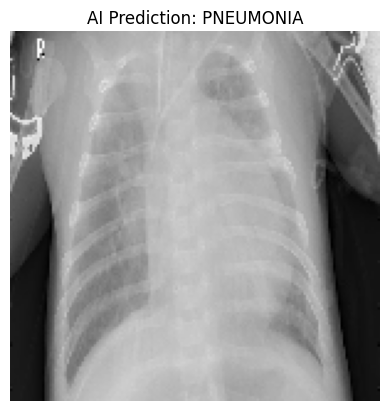

In [4]:
# IMPORTING LIBRARIES
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# SETTINGS
BATCH_SIZE = 32
IMG_HEIGHT = 150  # Smaller images = Faster training
IMG_WIDTH = 150
EPOCHS = 3
DATA_DIR = './chest_xray'

# Check if data exists before crashing
if not os.path.exists(DATA_DIR):
    print(f"ERROR: Could not find folder '{DATA_DIR}'. Please unzip the dataset first.")
    exit()

print("  Loading Data  ")

# LOADING DATA
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'), # If 'val' is empty, use 'test'
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=123
)

# Optimization
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# BUILDING CNN MODEL
print("  Building Model  ")

model = models.Sequential([
    # Layer 1: Rescale pixels from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Layer 2: Convolution (Finds edges and shapes)
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(), # Shrinks the image to save memory

    # Layer 3: Convolution (Finds textures)
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Layer 4: Convolution (Finds complex patterns)
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Layer 5: Flatten
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Output: 0 to 1
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# TRAINING
print("  Starting Quick Training  ")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("  Training Finished!  ")

# TESTING
test_path = os.path.join(DATA_DIR, 'test/PNEUMONIA')

first_image = os.listdir(test_path)[0]
img_path = os.path.join(test_path, first_image)

print(f"  Testing on: {first_image}  ")

# PREDICTION
img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0][0]


if score > 0.5:
    print(f"RESULT: PNEUMONIA Detected! (Confidence: {score:.2%})")
else:
    print(f"RESULT: Normal (Confidence: {1-score:.2%})")

# Showing the image
plt.imshow(img)
plt.title(f"AI Prediction: {'PNEUMONIA' if score > 0.5 else 'NORMAL'}")
plt.axis('off')
plt.show()

Failure Analysis

--- Loading Test Data for Analysis ---
Found 624 files belonging to 2 classes.
Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step

Total Test Images: 624
Number of Wrong Predictions: 166


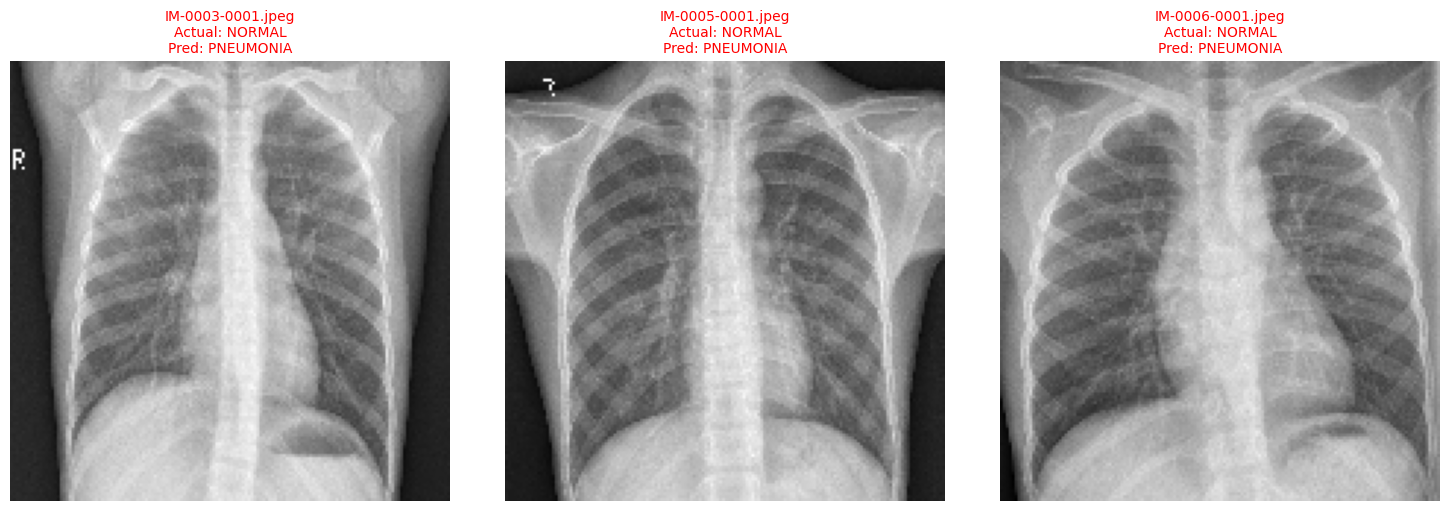


 Classification Report 
              precision    recall  f1-score   support

      Normal       0.99      0.29      0.45       234
   Pneumonia       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.81      0.73      0.69       624



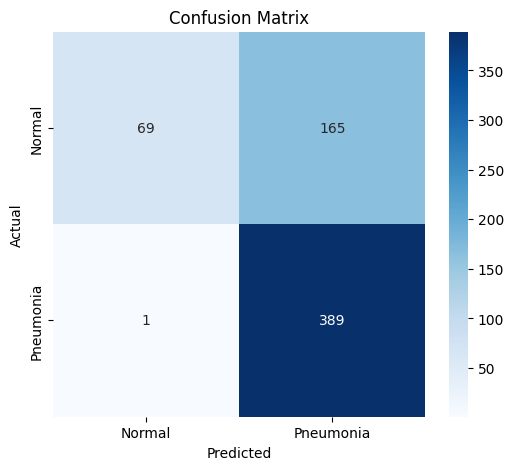

In [7]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#   1. RE-LOAD TEST DATA (Deterministic Order)
print("  Loading Test Data for Analysis  ")
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    shuffle=False  # IMPORTANT: Keep False to match filenames
)

#   2. GET PREDICTIONS & TRUE LABELS
print("Generating predictions...")
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32")

# Extract True Labels manually to ensure alignment
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

#   3. IDENTIFY FAILURES
# Find indices where Prediction != True Label
mismatches = np.where(predicted_labels.flatten() != true_labels)[0]
print(f"\nTotal Test Images: {len(true_labels)}")
print(f"Number of Wrong Predictions: {len(mismatches)}")

#   4. VISUALIZE FAILURES (FORCED METHOD)
import glob

# 1. Force-load filenames directly from the folder
# This bypasses the dataset object and goes straight to the hard drive
pneumonia_files = glob.glob(os.path.join(DATA_DIR, 'test/PNEUMONIA/*.jpeg'))
normal_files = glob.glob(os.path.join(DATA_DIR, 'test/NORMAL/*.jpeg'))
# Keras loads classes alphabetically: NORMAL first, then PNEUMONIA
all_files = sorted(normal_files) + sorted(pneumonia_files)

if len(mismatches) > 0:
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(mismatches[:3]):
        ax = plt.subplot(1, 3, i + 1)

        # Use the forced list
        img_path = all_files[idx]
        img_name = os.path.basename(img_path)

        img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.imshow(img)

        actual_cls = "PNEUMONIA" if true_labels[idx] == 1 else "NORMAL"
        pred_cls = "PNEUMONIA" if predicted_labels[idx] == 1 else "NORMAL"

        plt.title(f"{img_name}\nActual: {actual_cls}\nPred: {pred_cls}", color='red', fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 5. CONFUSION MATRIX
print("\n Classification Report ")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Pneumonia']))

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
